In [8]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [9]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [50]:
def ramsey(deld, psi0, t1, T, t2, delPrime, Omega0):
    #delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2Pulse1 = pulse(t1, Omega0, delPrime, 0.0, 0.0)
    pi2Pulse2 = pulse(t2, Omega0, delPrime, 0.0, 0.0)
    return pi2Pulse2@freeEvo@pi2Pulse1@psi0

def ramseyP(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2Pulse1 = pulse(t1, Omega0*Omega(nbar0,0,eta), delPrime, 0.0, 0.0)
    pi2Pulse2 = pulse(t2, Omega0*Omega(nbarf,0,eta), delPrime, 0.0, 0.0)
    return pi2Pulse2@pi2PhaseInjP@freeEvo@pi2Pulse1@psi0

def ramseyM(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    pi2Pulse1 = pulse(t1, Omega0*Omega(nbar0,0,eta), delPrime, 0.0, 0.0)
    pi2Pulse2 = pulse(t2, Omega0*Omega(nbarf,0,eta), delPrime, 0.0, 0.0)
    return pi2Pulse2@pi2PhaseInjP@freeEvo@pi2Pulse1@psi0

def RamseyErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf):
    return rhoee(ramseyM(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf)) - rhoee(ramseyP(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf))

In [48]:
psi0 = psi(0.0, 1.0)
Delta = 20.0 #*(2.0*np.pi)  #hz
Omega0 = 50.0 #*(2.0*np.pi) #hz
nbarf = 10 
nbar0 = 10
t1 = np.pi/(2.0*Omega0)
T = 20.0/Omega0
t2 = 3.0*np.pi/(2.0*Omega0)
eta = 0.00

pts = 100
delds = np.linspace(-20.0, 20.0, pts)
errSigPts1 = np.zeros(pts,)
errSigPts2 = np.zeros(pts,)
RhoeeM = np.zeros(pts,)
RhoeeP = np.zeros(pts,)
dif = np.zeros(pts,)
for ii in range(pts):
    #print(ii)
    #HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut):
    errSigPts1[ii] = RamseyErrSig(delds[ii], psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf)
    
x0 = -1.0
x1 = 1.0
tol = 1e-7
shift = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf), bracket=[x0,x1], xtol = tol).root

0.34977119455851674

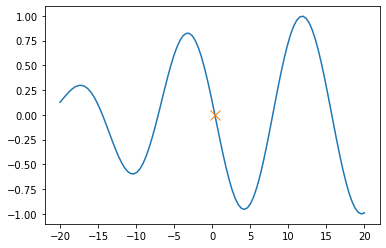

In [49]:
plt.plot(delds, errSigPts1)
plt.plot([shift],[0.0],marker='x',markersize=10)
shift

In [35]:
Omega(11,0,0.0)

1.0

In [96]:
psi0 = psi(1.0, 0.0)
lightshift = 0.5
Omega0 = 1.0
t1 = np.pi/(2.0*Omega0)
T = 1.0
t2 = np.pi/(2.0*Omega0)
pts = 1000
delds = np.linspace(-5.0, 5.0, pts)
rhos = np.zeros(pts)
for ii in range(pts):
    rhos[ii] = rhoee(ramsey(delds[ii], psi0, t1, T, t2, lightshift+delds[ii], Omega0))

Text(0.5, 0, 'Pulse ')

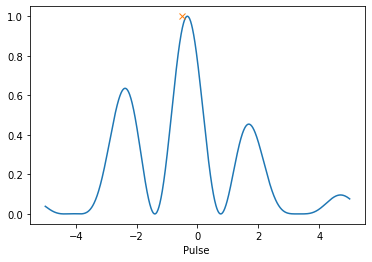

In [98]:
plt.plot(delds, rhos)
plt.plot([-0.5],[1.0],marker="x")
plt.xlabel("Pulse ")